In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 5.6MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 194kB 8.9MB/s 
     |████████████████████████████████| 1.2MB 12.7MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 12.8MB 225kB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [ ]:
# This directory is the working directory and has this colab notebook as well as the 'monojet_Zp2000.0_DM_50.0_chan3.csv' and th 'final_data.csv' files.

%cd gdrive/MyDrive/Colab\ Notebooks/ATLAS_GSoC

[Errno 2] No such file or directory: 'gdrive/MyDrive/Colab Notebooks/ATLAS_GSoC'
/content/gdrive/MyDrive/Colab Notebooks/ATLAS_GSoC


In this notebook, we will run a ready-made network starting from some ATLAS data, which is already normalized. There is also an alternative to train the network from scratch.  

## Look into the dataset

In [ ]:
import sys
sys.version

'3.7.10 (default, Feb 20 2021, 21:17:23) \n[GCC 7.5.0]'

In [ ]:
# This part is also covered in the 'make_dataset.py' script. Has been kept here for convenience

f = open('monojet_Zp2000.0_DM_50.0_chan3.csv', 'r+')
f2 = open('final_data.csv', 'w')

for line in f:
  line = line.replace(";", ",")
  b = line[:-2]
  c = b.split(',')
  indices = [i for i, x in enumerate(c) if x == 'j']
  empty_str = ""
  for index in indices:
    particle_info = c[index:index+5]
    particle_info = ','.join(particle_info)
    particle_info += '\n'
    f2.write(particle_info)
f.close()
f2.close()

We take a csv dataset, and open into Pandas (after importing pandas)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
 
data_path = 'final_data.csv'

data = pd.read_csv(data_path)
data.columns = ['Particle', 'E', 'pt', 'eta', 'phi']
data.drop(['Particle'], axis=1, inplace=True)
data['E'] = data['E'].apply(lambda x: np.log(float(x)))
data['pt'] = data['pt'].apply(lambda x: np.log(float(x)))
data['eta'] = data['eta'].apply(lambda x: float(x)/5)
data['phi'] = data['phi'].apply(lambda x: float(x)/3)

data[['E', 'pt', 'eta', 'phi']] = min_max_scaler.fit_transform(data[['E', 'pt', 'eta', 'phi']])
#data[['E', 'pt', 'eta', 'phi']] = standard_scaler.fit_transform(data[['E', 'pt', 'eta', 'phi']])

print(f"Total number of data points in the original data: {len(data)}\n")
print(f"ORIGINAL DATA: \n\n{data.head()}\n")

train = data.sample(frac=0.8, random_state=32)
test = data.drop(train.index)


print(f"\nTRAIN DATA: \n\n{train.head()}\n")
print(f"Total number of data points in the train data: {len(train)}\n")
print(train.describe())

print(f"\nTEST DATA: \n\n{test.head()}\n")
print(f"Total number of data points in the test data: {len(test)}\n")
print(test.describe())


Total number of data points in the original data: 22660

ORIGINAL DATA: 

          E        pt       eta       phi
0  0.588669  0.349997  0.272551  0.204491
1  0.529828  0.304804  0.728996  0.188644
2  0.092886  0.103455  0.554969  0.314688
3  0.427866  0.043150  0.213446  0.140413
4  0.727334  0.775154  0.595260  0.206818

                  E            pt           eta           phi
count  18128.000000  18128.000000  18128.000000  18128.000000
mean       0.460555      0.393428      0.507430      0.499358
std        0.202729      0.248278      0.156280      0.288323
min        0.000000      0.000000      0.008229      0.000000
25%        0.303708      0.169409      0.407126      0.248963
50%        0.477546      0.376613      0.507961      0.501726
75%        0.624978      0.615809      0.609114      0.747634
max        1.000000      1.000000      1.000000      0.999825
                 E           pt          eta          phi
count  4532.000000  4532.000000  4532.000000  4532.000000

Plotting the training data using matplotlib


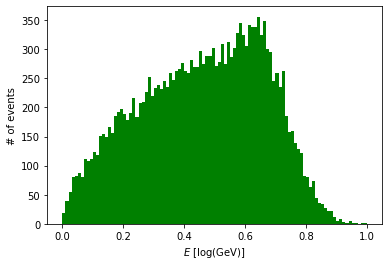

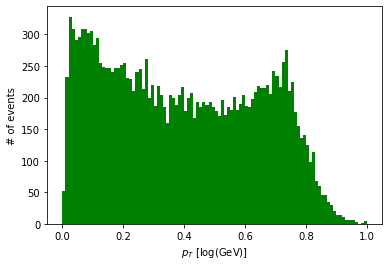

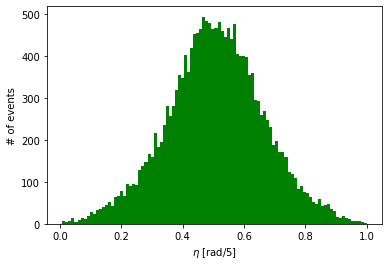

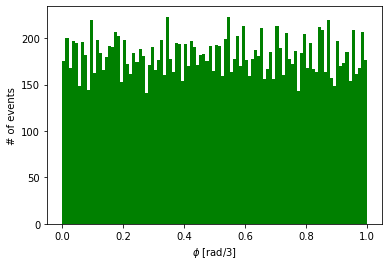

In [ ]:
import matplotlib.pyplot as plt

unit_list = ['[log(GeV)]', '[log(GeV)]', '[rad/5]', '[rad/3]']
variable_list = [r'$E$', r'$p_T$', r'$\eta$', r'$\phi$']
branches=["E","pt","eta","phi"]

n_bins = 100

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color='green', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('# of events')
    plt.savefig("plotOutput/fourmomentum_"+branches[kk],dpi=300)
    plt.show()

## Setting up the network

### Preparing the data

Adding the two datasets as TensorDatasets to PyTorch (also loading all other classes we'll need later)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

import numpy as np

train_x = train
test_x = test
train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

All the parameters used in this notebook are from the combination that gave the best results out of the 26 experiments that were conducted


In [ ]:
bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

### Preparing the network

Here we have an example network. Details aren't too important, as long as they match what was already trained for us...in this case we have a LeakyReLU, tanh activation function, and a number of layers that goes from 4 to 200 to 20 to 3 (number of features in the hidden layer that we pick for testing compression) and then back all the way to 4. 

In [ ]:
class AE_3D_400_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_400_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 400)
        self.en2 = nn.Linear(400, 400)
        self.en3 = nn.Linear(400, 200)
        self.en4 = nn.Linear(200, 3)
        self.de1 = nn.Linear(3, 200)
        self.de2 = nn.Linear(200, 400)
        self.de3 = nn.Linear(400, 400)
        self.de4 = nn.Linear(400, n_features)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def encode(self, x):
        return self.en4(self.leakyrelu(self.en3(self.leakyrelu(self.en2(self.leakyrelu(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.leakyrelu(self.de3(self.leakyrelu(self.de2(self.leakyrelu(self.de1(self.leakyrelu(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-400-400-200-3-200-400-400-out'

#model = AE_3D_400_LeakyReLU().double()
model = AE_3D_400_LeakyReLU()
model.to('cuda')

AE_3D_200_Tanh(
  (en1): Linear(in_features=4, out_features=400, bias=True)
  (en2): Linear(in_features=400, out_features=400, bias=True)
  (en3): Linear(in_features=400, out_features=200, bias=True)
  (en4): Linear(in_features=200, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=200, bias=True)
  (de2): Linear(in_features=200, out_features=400, bias=True)
  (de3): Linear(in_features=400, out_features=400, bias=True)
  (de4): Linear(in_features=400, out_features=4, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.1)
)

We now have to pick a loss function - MSE loss is appropriate for a compression autoencoder since it reflects the [(input-output)/input] physical quantity that we want to minimize. 

In [ ]:
from fastai.metrics import mse
from fastai.callback.data import CudaCallback

loss_func = nn.MSELoss()

#bn_wd = False  # Don't use weight decay for batchnorm layers
#true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=[recorder, CudaCallback])
#was: learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

## Training the new network

First, we want to find the best learning rate. The learning rate is a hyper-paramater that sets how much the weights of the network will change each step with respect to the loss gradient.

Then we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of learning rate, so we plot with a log scale.

A good value for the learning rates is then either:
- one tenth of the minimum before the divergence
- when the slope is the steepest

Learning rate with the minimum loss: 0.0015848932787775993
Learning rate with the steepest gradient: 0.0004786300996784121


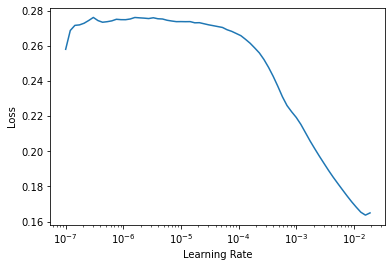

In [ ]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

Now we want to run the training!

User-chosen variables:
- n_epoch: The number of epochs, i.e how many times the to run through all of the training data once (i.e the 1266046 entries, see cell 2)
- lr: The learning rate. Either choose lr_min, lr_steep from above or set your own.
- We also use the ReduceLROnPlateau callback with the learner to reduce the learning rate when the performance starts plateauing. This helps in avoinding overshooting and missing the minimum of the cost function and also helps in preventing overfitting


In [ ]:
import time
from fastai.callback.tracker import *

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(n_epoch=250, lr_max=lr_min/10.0, cbs=ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2))
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

epoch,train_loss,valid_loss,time
0,0.248406,0.229256,00:00
0,0.248406,0.229256,00:00
1,0.212115,0.183737,00:00
1,0.212115,0.183737,00:00
2,0.169322,0.137978,00:00
2,0.169322,0.137978,00:00
3,0.123876,0.090720,00:01
3,0.123876,0.090720,00:01
4,0.080489,0.054302,00:00
4,0.080489,0.054302,00:00


Epoch 2: reducing lr to 7.194818142635876e-07
Epoch 5: reducing lr to 9.757267575785152e-07
Epoch 7: reducing lr to 1.2386863714236756e-06
Epoch 9: reducing lr to 1.572359733277104e-06
Epoch 11: reducing lr to 1.9733773142142745e-06
Epoch 13: reducing lr to 2.437689420750909e-06
Epoch 15: reducing lr to 2.960607875528923e-06
Epoch 17: reducing lr to 3.5368520622069915e-06
Epoch 19: reducing lr to 4.160603084652814e-06
Epoch 21: reducing lr to 4.82556232416283e-06
Epoch 23: reducing lr to 5.525014377411444e-06
Epoch 25: reducing lr to 6.2518975007412005e-06
Epoch 27: reducing lr to 6.998871014230157e-06
Epoch 29: reducing lr to 7.758392002237588e-06
Epoch 31: reducing lr to 8.522790845109725e-06
Epoch 33: reducing lr to 9.284348666763905e-06
Epoch 35: reducing lr to 1.0035375279662629e-05
Epoch 37: reducing lr to 1.0768286840091588e-05
Epoch 39: reducing lr to 1.1475681140199693e-05
Epoch 41: reducing lr to 1.2150417567063435e-05
Epoch 43: reducing lr to 1.2785681309275893e-05
Epoch 45:

Then we plot the loss as a function of batches and epochs to check if we reach a plateau.

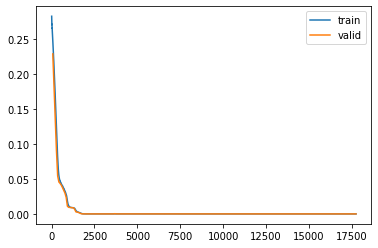

In [ ]:
recorder.plot_loss()

Then we evaluate the MSE on this network - it should be of the order of 0.001 or less if all has gone well...if it has not trained as well (note the pesky 0-mass peak above...) then it's going to be a bit higher.

In [ ]:
learn.validate()

(#1) [7.80453206061793e-07]

Let's plot all of this, with ratios (thanks to code by Erik Wallin)

## Plotting the outputs of the network

Lazy-save of our output files (they'll also be on screen)

In [ ]:
import os
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

A function in case we want to un-normalize and get back to physical quantities...

In [ ]:
def custom_unnormalize(df):
    df['eta'] = df['eta'] * 5
    df['phi'] = df['phi'] * 3
    df['E'] = 10**df['E']
    #df['m'] = 10**df['m']
    df['pt'] = 10**(df['pt'])
    return df

Make the histograms from the dataset...

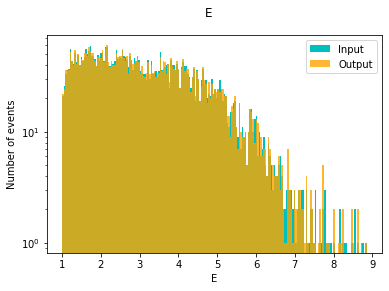

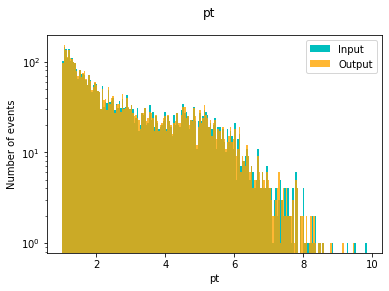

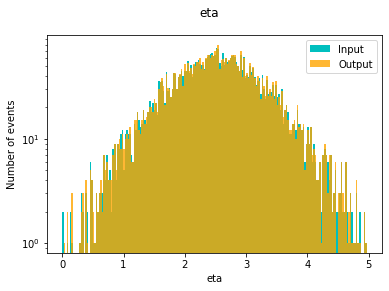

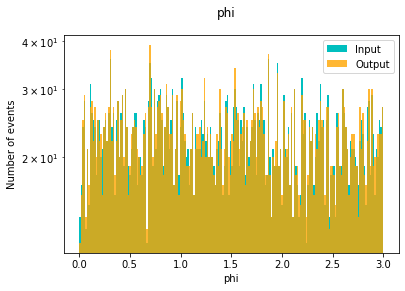

In [ ]:
import numpy as np

plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cuda')

save = True # Option to save figure

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float)
#data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float).double()
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test.columns)
pred_df = pd.DataFrame(pred, columns=test.columns)

unnormalized_data_df = custom_unnormalize(data_df)
unnormalized_pred_df = custom_unnormalize(pred_df)    
    
alph = 0.8
n_bins = 200
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(test.columns[kk])
    plt.xlabel(test.columns[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,test.columns[kk]+'.png'))
    plt.legend()

In [ ]:
def getRatio(bin1,bin2):
    bins = []
    for b1,b2 in zip(bin1,bin2):
        if b1==0 and b2==0:
            bins.append(0.)
        elif b2==0:
            bins.append(None)
        else:
            bins.append((float(b2)-float(b1))/b1)
    return bins   

rat = getRatio(n_hist_data,n_hist_pred)
print(rat)

[-0.05263157894736842, 0.0, 0.0, 0.0, -0.13043478260869565, -0.043478260869565216, 0.11538461538461539, 0.07142857142857142, 0.0, -0.06666666666666667, 0.05555555555555555, 0.0, -0.06896551724137931, 0.1, -0.07142857142857142, 0.05555555555555555, -0.10526315789473684, 0.125, -0.04, 0.14285714285714285, -0.14285714285714285, -0.05555555555555555, 0.05263157894736842, -0.11538461538461539, 0.1, 0.0, 0.058823529411764705, -0.037037037037037035, -0.041666666666666664, 0.19047619047619047, -0.18518518518518517, 0.16666666666666666, 0.0, -0.11538461538461539, 0.15, 0.034482758620689655, -0.0625, 0.0, -0.03225806451612903, 0.09090909090909091, 0.1111111111111111, -0.15, 0.11764705882352941, 0.09523809523809523, -0.09523809523809523, 0.0, -0.17391304347826086, 0.07692307692307693, 0.037037037037037035, 0.05555555555555555, 0.041666666666666664, -0.04, 0.0, 0.08333333333333333, -0.1111111111111111, -0.1111111111111111, -0.03571428571428571, 0.25, 0.0, -0.13793103448275862, -0.0625, 0.0, 0.0, 0